In [1]:
'''
File: PairsTrading01
Author: Aleksi Lassila <aleksi.lassila@gmail.com>

Title: Pairs Trading Strategy
Version: 1.02
Date: 6.1.2021

Description: Pairs trading project that finds cointegrated pairs, runs simple optimization 
             and then back- and forward-tests profitability using the best parameters from optimization.
             Program uses yfinance to download market data from Yahoo (https://pypi.org/project/yfinance/).
             Program is still work in progress so use it for educational purposes only.
''';

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from itertools import product
from pylab import plt, mpl
from scipy.stats import linregress
from scipy.stats import pearsonr
from datetime import datetime

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
# Symbols
stock = ['DOOR', 'APOG', 'EA', 'ZNGA', 'HES', 'COP', 'CMS', 'LNT', 'MAR', 'BBY', 'KAMN', 'WWD', 'CROX', 'GIII', 'HEP', 'VLP',
       'DECK', 'OXM', 'WAT', 'VAR', 'AB', 'KKR', 'BBY', 'TECD', 'ABCD', 'PFBC', 'WDAY', 'HUBS', 'CNHI', 'DE', 'BEN', 'BX',
       'LKFN', 'WSFS', 'PDS', 'SNP', 'CTB', 'GT']
etf = ['AAXJ', 'EWH', 'EWJ', 'VT', 'EWH', 'VWO', 'EWL', 'VGK', 'EEM', 'EPP', 'EWS', 'EZA', 'EWH', 'IEMG', 'TLT', 'VNQ', 
        'VXUS', 'EWH', 'TLT', 'IYR', 'TLT', 'SCHH', 'TLT', 'RWR', 'EWH', 'EZA', 'FXU', 'IEF', 'IYR', 'LQD', 'EPHE', 'LQD', 
        'TLT', 'XLU', 'TLT', 'VNQ', 'EEM', 'EWH', 'IXUS', 'EWH', 'SPHD', 'TIP', 'EWU', 'FEZ']

In [4]:
# Set the symbol group, start and end dates
group = etf
start_date = '2018-01-01'
end_date = '2020-12-31'
# Download data from Yahoo
raw_data = yf.download(group, start=start_date, end=end_date)
# Select data from Open, High, Low, Close, Adj Close, Volume
raw_data = raw_data['Adj Close']

[*********************100%***********************]  28 of 28 completed


In [5]:
raw_data.head(2)

,AAXJ,EEM,EPHE,EPP,EWH,EWJ,EWL,EWS,EWU,EZA,...,SCHH,SPHD,TIP,TLT,VGK,VNQ,VT,VWO,VXUS,XLU
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,74.019325,44.933556,38.336212,43.180923,23.677608,57.453320,33.582359,23.566135,32.240936,56.275639,...,37.794586,37.228683,107.565292,117.613815,53.784252,73.222107,70.000015,42.997639,52.705711,47.217300
2018-01-03,74.665619,45.364082,38.982822,43.440407,23.815752,58.244267,33.751595,23.860266,32.187416,56.517029,...,37.712658,37.211185,107.669289,118.176140,53.973953,73.009552,70.476578,43.411972,53.073128,46.846375


In [6]:
# Test data for NaN values
for symbol in raw_data:
    if raw_data[symbol].isnull().sum():
        print('{} has NaN values'.format(symbol))

In [7]:
# Drop symbols with NaN values
raw_data.dropna(axis=1, inplace=True)
raw_data.head(2)

,AAXJ,EEM,EPHE,EPP,EWH,EWJ,EWL,EWS,EWU,EZA,...,SCHH,SPHD,TIP,TLT,VGK,VNQ,VT,VWO,VXUS,XLU
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,74.019325,44.933556,38.336212,43.180923,23.677608,57.453320,33.582359,23.566135,32.240936,56.275639,...,37.794586,37.228683,107.565292,117.613815,53.784252,73.222107,70.000015,42.997639,52.705711,47.217300
2018-01-03,74.665619,45.364082,38.982822,43.440407,23.815752,58.244267,33.751595,23.860266,32.187416,56.517029,...,37.712658,37.211185,107.669289,118.176140,53.973953,73.009552,70.476578,43.411972,53.073128,46.846375


In [8]:
# Split data into training and testing data
train_test_ratio = 0.7 # training period of all data, ie. 70 %
split = int(len(raw_data) * train_test_ratio)
train = raw_data.iloc[:split].copy() 
test = raw_data.iloc[split:].copy()

In [9]:
# Test and find cointegrated pairs
def find_cointegrated_pairs(data, pval):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            results = coint(S1, S2)
            score = results[0]
            pvalue = results[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < pval: 
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

Wall time: 9.25 s


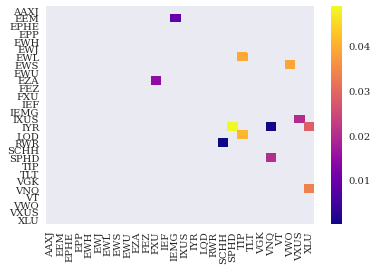

In [10]:
# Find cointegrated pairs using training data
# Set p-value, ie. 0.1 = 90, 0.05 = 95 cointegration
pval = 0.05
%time scores, pvalues, pairs = find_cointegrated_pairs(train, pval)
seaborn.heatmap(pvalues, xticklabels = train.columns, yticklabels = train.columns, cmap = 'plasma', mask = (pvalues >= pval));

In [11]:
print('Found {} pairs: {}'.format(len(pairs), pairs))

Found 12 pairs: [('EEM', 'IEMG'), ('EWL', 'TIP'), ('EWS', 'VWO'), ('EZA', 'FXU'), ('IXUS', 'VXUS'), ('IYR', 'SPHD'), ('IYR', 'VNQ'), ('IYR', 'XLU'), ('LQD', 'TIP'), ('RWR', 'SCHH'), ('SPHD', 'VNQ'), ('VNQ', 'XLU')]


In [12]:
# Returns cointegration
def get_coint(s1, s2, data):
    score, pvalue, _ = coint(data[s1], data[s2])
    return 1 - pvalue # returns cointegration confidence =  1 - pvalue

In [13]:
# Returns correlation
def get_corr(s1, s2, data):
    corr, _ = pearsonr(data[s1], data[s2])
    return corr

In [14]:
# Get cointegration confidences and correlations for pairs
coint_pairs = []
correlation = []

for i in pairs:    
    pvalue = get_coint(i[0], i[1], train)
    corr = get_corr(i[0], i[1], train)
    coint_pairs.append([i[0], i[1], pvalue, corr])

In [15]:
# Insert coint_pairs to dataframe and sort by cointegration confidence
pairs_table = pd.DataFrame(coint_pairs, columns=['symbolA', 'symbolB', 'coint', 'correlation'])
pairs_table.sort_values(by='coint', ascending=False)

,symbolA,symbolB,coint,correlation
9,RWR,SCHH,0.999789,0.999968
6,IYR,VNQ,0.999278,0.999515
0,EEM,IEMG,0.990316,0.999668
3,EZA,FXU,0.985161,-0.755481
4,IXUS,VXUS,0.980085,0.999769
10,SPHD,VNQ,0.979782,0.926073
7,IYR,XLU,0.971325,0.975176
11,VNQ,XLU,0.966323,0.972100
2,EWS,VWO,0.961147,0.923887
1,EWL,TIP,0.960631,0.924274


In [16]:
# Set symbol for testing, coint > 0.95, correlation > 0.7
symbolA = 'IYR'
symbolB = 'XLU'

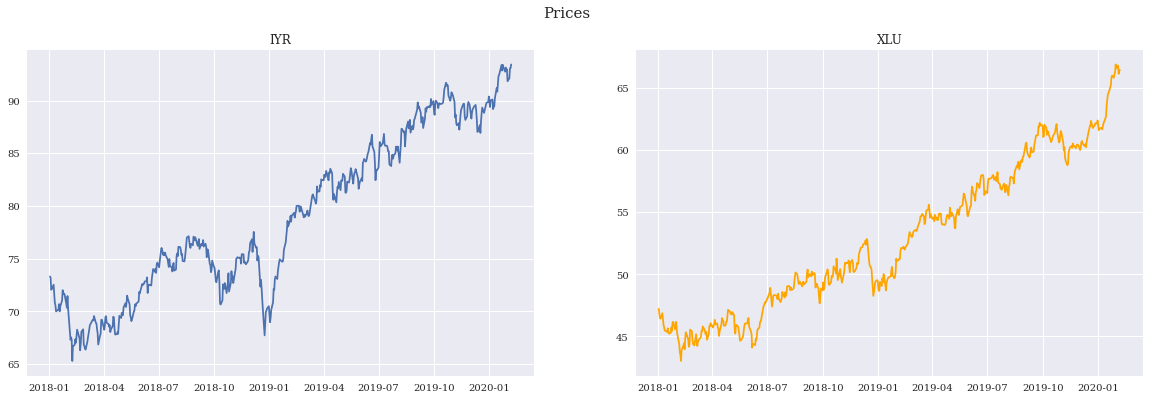

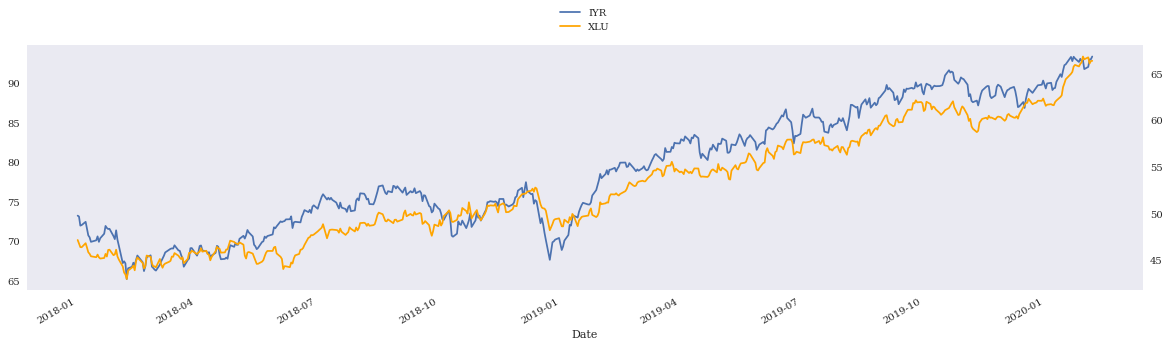

In [17]:
# Plot prices
plt.subplots(1, 2, figsize=(20, 6), sharex=True, sharey=False)
plt.suptitle('Prices', fontsize=15)
plt.subplot(121, title=symbolA)
plt.plot(train[symbolA])
plt.subplot(122, title=symbolB)
plt.plot(train[symbolB], c = 'orange');

fig, ax = plt.subplots()
plt.rcParams['axes.grid'] = False
ax = train[symbolA].plot(label=symbolA, figsize=(20, 5))
ax2 = ax.twinx()
ax2.plot(train[symbolB], label=symbolB, c = 'orange')
fig.legend(loc='upper center');

LinregressResult(slope=0.761249762207679, intercept=-7.272560035866114, rvalue=0.9751758076306871, pvalue=0.0, stderr=0.007536883843145748)


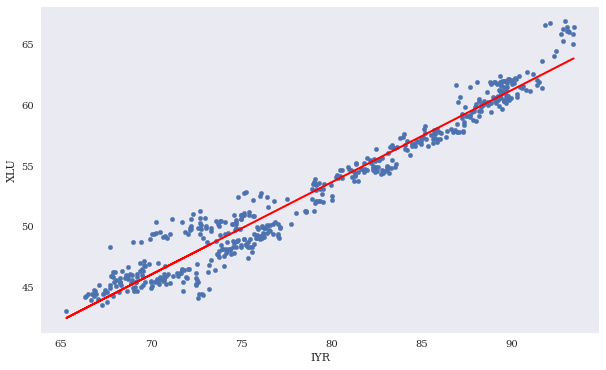

In [18]:
# Scatter plot with linear regression
x, y = train[symbolA], train[symbolB]
reg = np.polyfit(x, y, deg=1)
ax = train.plot(kind='scatter', x=symbolA, y=symbolB, figsize=(10, 6))
ax.plot(train[symbolA], np.polyval(reg, train[symbolA]), 'r', lw=2);
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(linregress(x,y))

Correlation for pair IYR-XLU is 0.9752
Cointegration for pair IYR-XLU is 0.9713


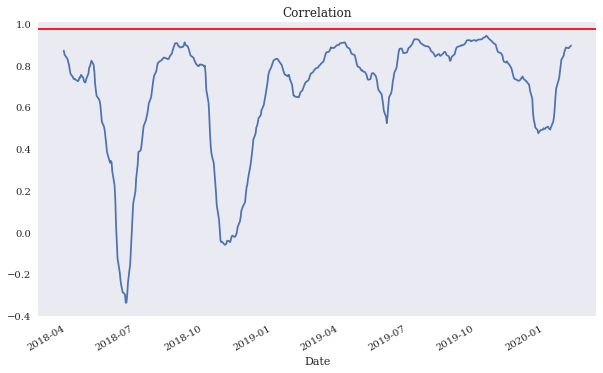

In [20]:
# Rolling correlation for n days and for full training dataset
cor_period = 60 # Set correlation period
correlation = train.corr().loc[symbolA, symbolB]
cointegration = get_coint(symbolA, symbolB, train)
ax = train[symbolA].rolling(window=cor_period).corr(train[symbolB]).plot(figsize=(10, 6), title='Correlation') # rolling correlation
ax.axhline(correlation, c='r'); # full train dataset correlation
print('Correlation for pair {}-{} is {:0.4f}'.format(symbolA, symbolB, correlation))
print('Cointegration for pair {}-{} is {:0.4f}'.format(symbolA, symbolB, cointegration))

In [21]:
# Function to calculate pair spread using logarithmic prices
def get_spread(s1, s2, data):
    return np.log(data[s1]) - np.log(data[s2])

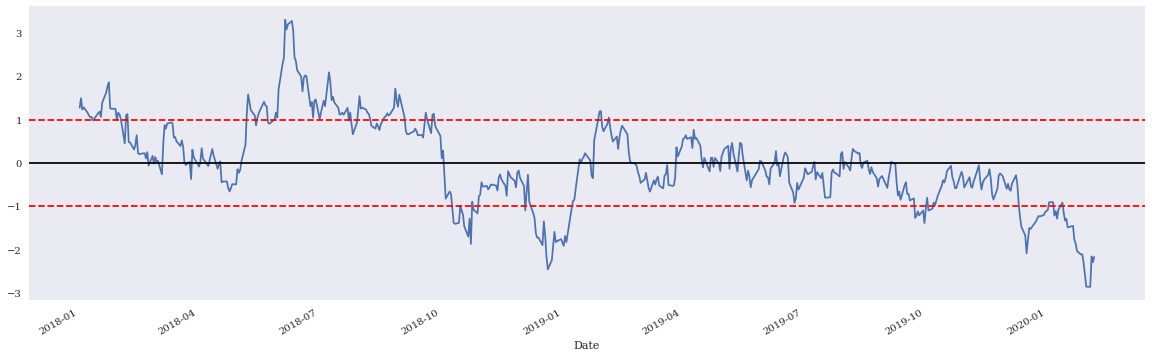

In [22]:
# Plot z-score for full training data
spread = get_spread(symbolA, symbolB, train)
((spread - spread.mean()) / spread.std()).plot(figsize=(20, 6)) # z-score
plt.axhline(0, c = 'black')
plt.axhline(1.0, c = 'r', ls = '--')
plt.axhline(-1.0, c = 'r', ls = '--');

In [23]:
# Backtest function
def backtest(equity, plotting, period, entry_level, exit_level, data, s1, s2):
    temp_data = data.copy()
    spread = get_spread(s1, s2, data)
    spread_mavg1 = spread.rolling(1).mean()
    spread_mavg = spread.rolling(period).mean()
    spread_std = spread.rolling(period).std()
    zscore = (spread_mavg1 - spread_mavg) / spread_std    
    temp_data['zscore'] = zscore
    temp_data.dropna(inplace=True)
    
    position_list = []
    position = 0
    
    for n in temp_data['zscore']:
        if n >= entry_level:
            position = -1
        elif n <= -entry_level:
            position = 1
        elif position == -1 and n <= exit_level:
            position = 0
        elif position == 1 and n >= -exit_level:
            position = 0
        position_list.append(position)
    
    temp_data['direction'] = position_list
    temp_data['strategy'] = temp_data['direction'].shift(1) * (temp_data['returnsA'] - temp_data['returnsB'])
    temp_data.dropna(inplace=True) 
    temp_data['equity'] = temp_data['strategy'].cumsum().apply(np.exp) * equity # rolling equity
    temp_data['cummax'] = temp_data['equity'].cummax() # cumulative max equity
    temp_data['drawdown'] = temp_data['cummax'] - temp_data['equity'] # drawdown in money
    temp_data['drawdownP'] = 1 - temp_data['equity'] / temp_data['cummax'] # drawdown-%
    profit_p = (temp_data['equity'][-1] / equity - 1) * 100 # profit-%    
    timetemp = temp_data['drawdown'][temp_data['drawdown'] == 0] # identifies highs when drawdown must be 0
    periods = (timetemp.index[1:].to_pydatetime() - timetemp.index[:-1].to_pydatetime()) # timedelta values between all highs
    t_per = periods.max() # longest drawdown
    maxdd = temp_data['drawdown'].max() # max drawdown in money
    maxdd_p = temp_data['drawdownP'].max() * 100 # max drawdown-%
    t_maxdd = temp_data['drawdownP'].idxmax() # max drawdown in time (timestamp)
    profit_f = maxdd / temp_data['equity'][-1] # profit factor formula
    
    if plotting:
        temp_data[['equity', 'cummax']].plot(figsize=(15, 6))
        plt.axvline(t_maxdd, c='r', alpha=0.5, label='largest DD-%')        
        plt.legend(['Equity', 'Balance', 'Largest DD-%']) # Balance = closed equity
    
    return profit_f, profit_p, temp_data['equity'][-1], maxdd, maxdd_p, t_per, t_maxdd

In [24]:
# Function to create a dafaframe for optimizing and backtest
def create_df(data, s1, s2):
    temp_data = pd.DataFrame(index=data.index.copy())
    temp_data[symbolA], temp_data[symbolB] = data[symbolA], data[symbolB]
    temp_data['returnsA'] = np.log(data[symbolA] / data[symbolA].shift(1))
    temp_data['returnsB'] = np.log(data[symbolB] / data[symbolB].shift(1))
    return temp_data

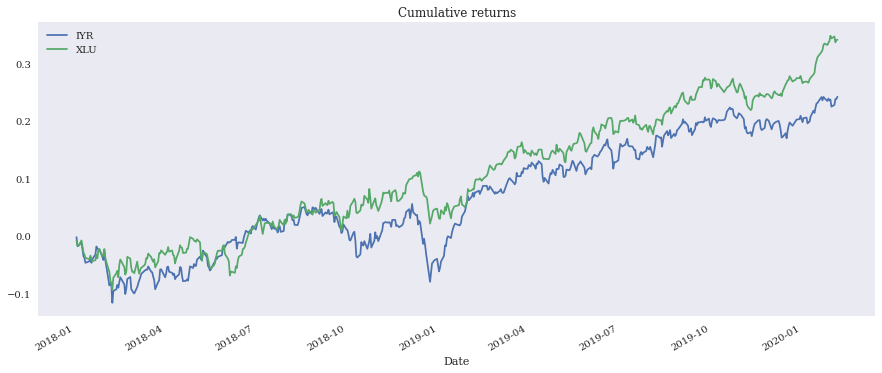

In [25]:
# Create a dafaframe from training data for optimizing and backtest and plot cumulative returns
data2 = create_df(train, symbolA, symbolB)
data2[['returnsA', 'returnsB']].cumsum().plot(figsize=(15, 6))
plt.title('Cumulative returns')
plt.legend([symbolA, symbolB]);

Backtest pair IYR-XLU from 2018-01-02 to 2020-02-06:

Optimization runs: 80

    Period  Entry  Exit  ProfitFactor    Profit%        Equity       MaxDD  \
25      40    1.0   0.5      0.056790  35.208206  13520.820570  767.851017   
33      50    1.0   0.5      0.057742  31.721886  13172.188564  760.590386   
32      50    1.0   0.0      0.056727  30.500661  13050.066101  740.288701   
40      60    1.0   0.0      0.057509  28.450558  12845.055836  738.709383   
24      40    1.0   0.0      0.059724  26.958931  12695.893054  758.245870   

      MaxDD% MaxDDtime MaxDDpoint  
25  6.912659  106 days 2018-10-24  
33  6.912659  192 days 2018-10-24  
32  6.912659  115 days 2018-10-24  
40  6.912659  192 days 2018-10-24  
24  6.912659   78 days 2018-10-24  

Selected parameters:
Period: 40
Entry level: 1.0
Exit level: 0.5

Equity: 13520.82 €
Profit: 35.21 %
Drawdown: 6.91 %
Max days in drawdown: 106 days, 0:00:00


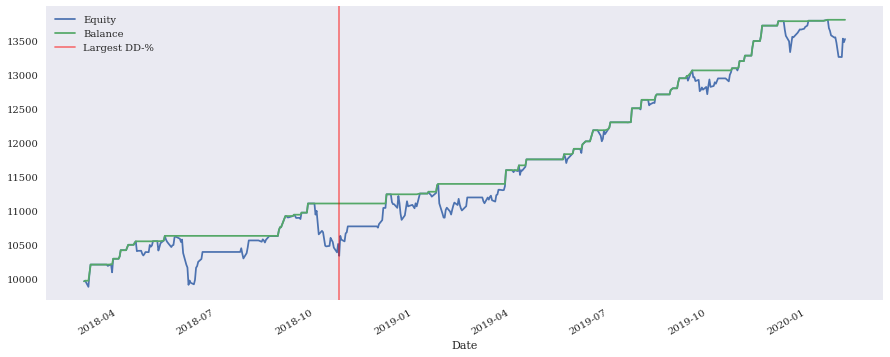

In [26]:
# Optimize for best trading parameters
bt_period = range(10, 101, 10)
bt_entryLevel = np.arange(1, 3, 0.5)
bt_exitLevel = np.arange(0, 1, 0.5)
account_balance = 10000

results = pd.DataFrame()

for BTperiod, BTentry, BTexit in product(bt_period, bt_entryLevel, bt_exitLevel):
    profit_f, profit_p, equity, maxdd, maxdd_p, t_per, t_maxdd = backtest(account_balance, False, BTperiod, 
                                                                           BTentry, BTexit, data2, symbolA, symbolB)    
    results = results.append(pd.DataFrame({'Period': BTperiod, 'Entry': BTentry, 'Exit': BTexit, 'ProfitFactor': profit_f,
                                           'Profit%': profit_p, 'Equity': equity, 'MaxDD': maxdd, 'MaxDD%': maxdd_p,
                                           'MaxDDtime': t_per, 'MaxDDpoint': t_maxdd},
                                          index=[0]), ignore_index=True)

start_d = datetime.date(data2.index[0])
end_d = datetime.date(data2.index[-1])
print('Backtest pair {}-{} from {} to {}:\n'.format(symbolA, symbolB, start_d, end_d))
print('Optimization runs: {}\n'.format(len(results)))
print(results.sort_values(by='Profit%', ascending=False).head(5))

per, ent, exit, profit_f, profit_p  = results.sort_values(by='Profit%', ascending=False).iloc[0][0:5]
profit_f, profit_p, equity, maxdd, maxdd_p, t_per, t_maxdd = backtest(account_balance, True, int(per), ent, exit,
                                                                       data2, symbolA, symbolB)

print('\nSelected parameters:')
print('Period: {}'.format(per))
print('Entry level: {}'.format(ent))
print('Exit level: {}'.format(exit))
print('\nEquity: {:0.2f} €'.format(equity))
print('Profit: {:0.2f} %'.format(profit_p))
print('Drawdown: {:0.2f} %'.format(maxdd_p))
print('Max days in drawdown: {}'.format(t_per))

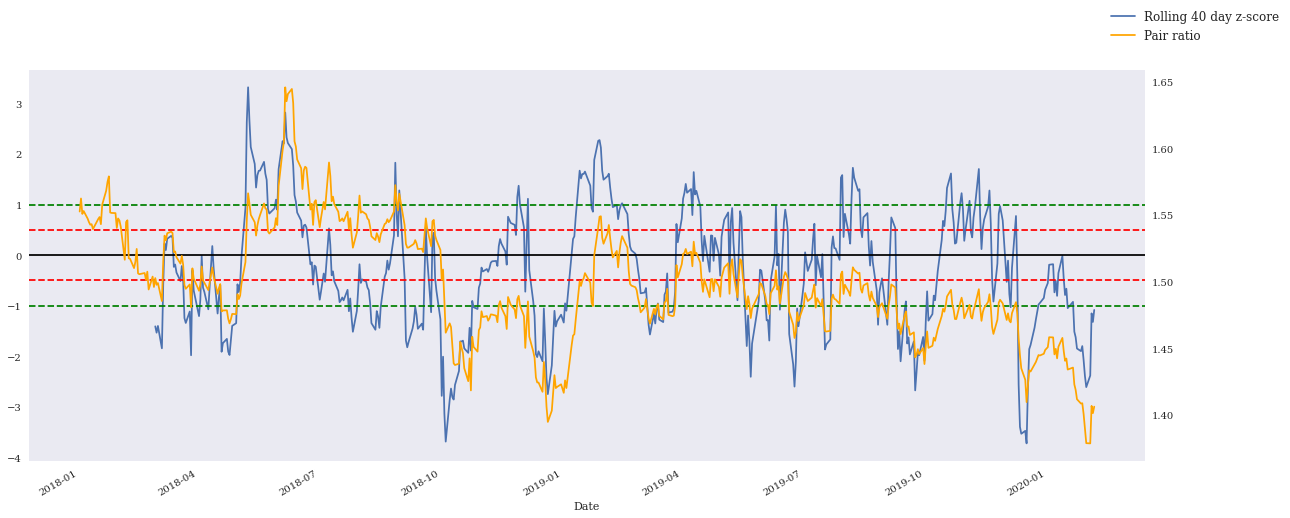

In [27]:
# Draw z-score, entry and exit levels using opmized parameters and pair-ratio
spread_mavg1 = spread.rolling(1).mean()
spread_mavg = spread.rolling(per).mean()
spread_std = spread.rolling(per).std()
zscore = (spread_mavg1 - spread_mavg) / spread_std

fig, ax = plt.subplots()
ax = zscore.plot(label = 'Rolling {} day z-score'.format(per), figsize=(20, 8))
plt.axhline(0, c = 'black')
plt.axhline(ent, c ='g',ls='--')
plt.axhline(-ent, c ='g',ls='--')
plt.axhline(exit, c ='r',ls='--')
plt.axhline(-exit, c ='r',ls='--')
ax2 = ax.twinx()
ratio = train[symbolA] / train[symbolB]
ax2.grid(False)
ax2.plot(ratio, label='Pair ratio', c = 'orange')
fig.legend(loc='upper right', fontsize='large');

In [28]:
# Forward test with the optimized values

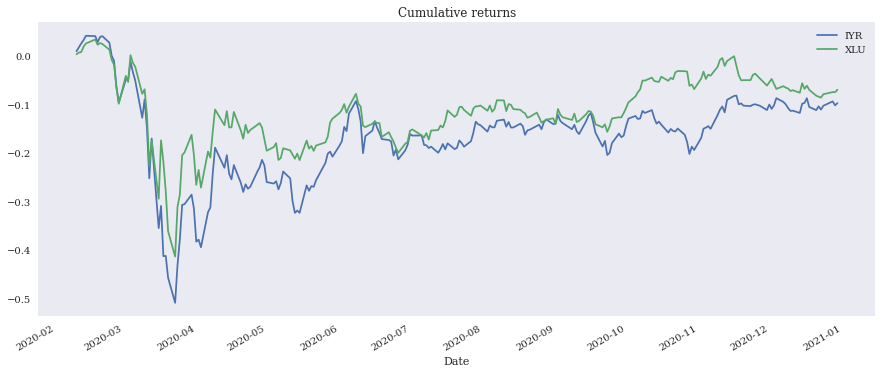

In [29]:
# Create a dafaframe from testing data, backtest and plot cumulative returns
data2 = create_df(test, symbolA, symbolB)
data2[['returnsA', 'returnsB']].cumsum().plot(figsize=(15, 6))
plt.title('Cumulative returns')
plt.legend([symbolA, symbolB]);


Backtest pair IYR-XLU from 2020-02-07 to 2020-12-30:
Equity: 11369.34 €
Profit: 13.69 %
Drawdown: 8.62 %
Max days in drawdown: 90 days, 0:00:00


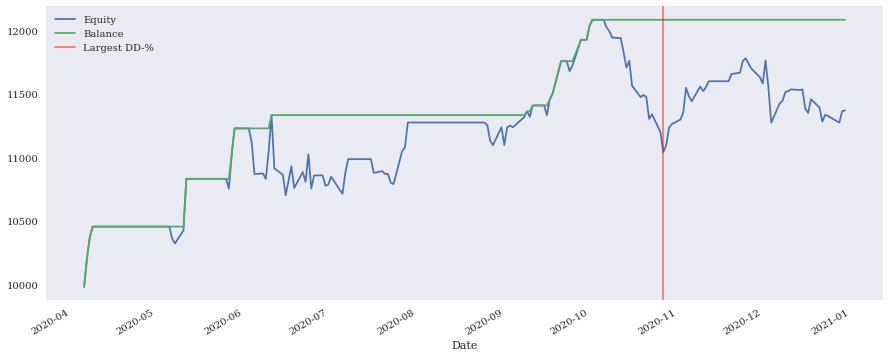

In [30]:
profit_f, profit_p, equity, maxdd, maxdd_p, t_per, t_maxdd = backtest(account_balance, True, int(per), ent, exit,
                                                                       data2, symbolA, symbolB)
start_d = datetime.date(data2.index[0])
end_d = datetime.date(data2.index[-1])
print('\nBacktest pair {}-{} from {} to {}:'.format(symbolA, symbolB, start_d, end_d))
print('Equity: {:0.2f} €'.format(equity))
print('Profit: {:0.2f} %'.format(profit_p))
print('Drawdown: {:0.2f} %'.format(maxdd_p))
print('Max days in drawdown: {}'.format(t_per))

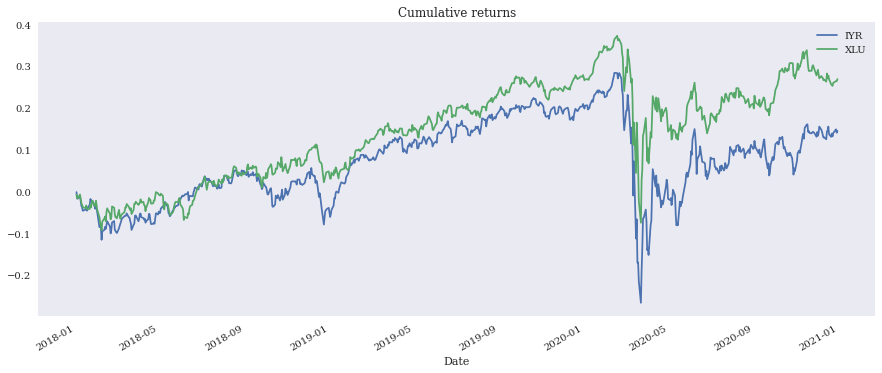

In [31]:
# Create a dafaframe from full data, backtest and plot cumulative returns
data2 = create_df(raw_data, symbolA, symbolB)
data2[['returnsA', 'returnsB']].cumsum().plot(figsize=(15, 6))
plt.title('Cumulative returns')
plt.legend([symbolA, symbolB]);


Backtest pair IYR-XLU from 2018-01-02 to 2020-12-30:
Equity: 15003.24 €
Profit: 50.03 %
Drawdown: 12.50 %
Max days in drawdown: 106 days, 0:00:00


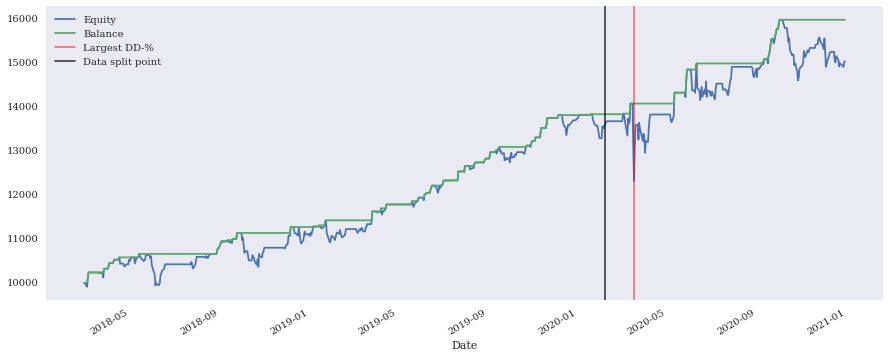

In [32]:
# Run full data test with backtester
profit_f, profit_p, equity, maxdd, maxdd_p, t_per, t_maxdd = backtest(account_balance, True, int(per), ent, exit,
                                                                       data2, symbolA, symbolB)
start_d = datetime.date(data2.index[0])
end_d = datetime.date(data2.index[-1])
print('\nBacktest pair {}-{} from {} to {}:'.format(symbolA, symbolB, start_d, end_d))
print('Equity: {:0.2f} €'.format(equity))
print('Profit: {:0.2f} %'.format(profit_p))
print('Drawdown: {:0.2f} %'.format(maxdd_p))
print('Max days in drawdown: {}'.format(t_per))
plt.axvline(raw_data.index[split], c='black', alpha=0.7) # line at data split
plt.legend(['Equity', 'Balance', 'Largest DD-%', 'Data split point']);